## Citibank: Value stocks could shine after US election, no matter who wins

Citi's Head of American Trading Strategy, Alexander Altmann, says:
- "Value always performed pretty well in the six months after the election."
- "The magnitude of that performance did, however, vary depending on what kind of election outcome we get."

In [1]:
import numpy as np
import pandas as pd

In [2]:
ff5_panel = pd.read_csv("ff5.csv", index_col=0)

In [3]:
ff5_panel.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
mthyr,,,,,,
196307,-0.39,-0.47,-0.83,0.66,-1.15,0.27
196308,5.07,-0.79,1.67,0.40,-0.40,0.25
196309,-1.57,-0.48,0.18,-0.76,0.24,0.27
196310,2.53,-1.29,-0.10,2.75,-2.24,0.29
196311,-0.85,-0.84,1.71,-0.45,2.22,0.27


Let's define some notation for random variables.  Let $R_p$ be the cumulative HML portfolio return from February to July in presidential inauguration years, and $R_n$ be the same return in the same period in non-presidential inauguration years.

We are interested in a few questions:
1. Test 1: Is $E(R_p)$ significantly different from 0?
2. Test 2: Is $E(R_p)$ significantly different from $E(R_n)$?
3. Robustness Check: Do other risk factors explain away $E(R_p)$?

### Test 1

Assume
$$
\hat{\mu}_p \sim N(\mu_p, \frac{\sigma_p^2}{n}),
$$
also assume there's no heteroskedasticity or autocorrelation in our sample data.

In [4]:
inaug_year = [i for i in range(2017, 1962, -4)]

In [5]:
# inauguration years
inaug_year

[2017,
 2013,
 2009,
 2005,
 2001,
 1997,
 1993,
 1989,
 1985,
 1981,
 1977,
 1973,
 1969,
 1965]

In [6]:
ff5_roll6m = ((1 + ff5_panel / 100).rolling(window=6).apply(np.prod) - 1) * 100

In [7]:
inaug_ym = [i * 100 + 7 for i in range(2017, 1962, -4)]

In [8]:
presid_elec_panel = ff5_roll6m.loc[inaug_ym]

In [9]:
presid_elec_panel["HML"].agg(["mean", "std"])

mean    5.248202
std     7.195875
Name: HML, dtype: float64

In [10]:
# test whether the mean is significant
presid_elec_panel["HML"].mean() / presid_elec_panel["HML"].std() * np.sqrt(len(presid_elec_panel.index))

2.7289211300947183

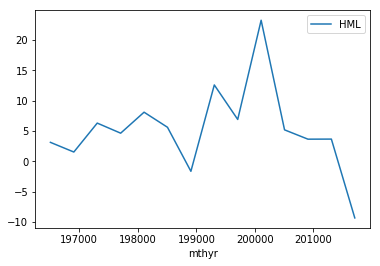

In [12]:
presid_elec_panel[["HML"]].plot()

So the mean is significantly different from 0 at $5\%$ level.

### Test 2

We want to test for difference between two means, which yields a 2-sample $t$-statistic:
$$
t = \frac{(\hat{\mu}_p - \hat{\mu}_n) - (\mu_p - \mu_n)}{\sqrt{\frac{s_1^2}{n_p} + \frac{s_2^2}{n_n} }}
$$

In [13]:
nonpresid_elec_panel = ff5_roll6m.loc[~ff5_roll6m.index.isin(inaug_ym)]
nonpresid_elec_panel = nonpresid_elec_panel.dropna()
nonpresid_elec_panel = nonpresid_elec_panel.loc[nonpresid_elec_panel.index.map(lambda x: x % 100 == 7)]

In [14]:
# exclude 2020, since COVID-19 is an outlier
# nonpresid_elec_panel = nonpresid_elec_panel.iloc[:-1]

In [15]:
nonpresid_elec_panel["HML"].agg(["mean", "std"])

mean    0.737339
std     8.058814
Name: HML, dtype: float64

#### Non-presidential t-stat

In [16]:
nonpresid_elec_panel["HML"].mean() / nonpresid_elec_panel["HML"].std() * np.sqrt(len(nonpresid_elec_panel))

0.5999707785511226

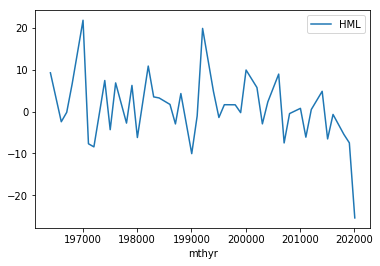

In [17]:
nonpresid_elec_panel[["HML"]].plot()

#### Difference in means

In [18]:
n_p = len(presid_elec_panel.index)
n_n = len(nonpresid_elec_panel.index)

(presid_elec_panel["HML"].mean() - nonpresid_elec_panel["HML"].mean()) / \
    np.sqrt( presid_elec_panel["HML"].var() / n_p + nonpresid_elec_panel["HML"].var() / n_n )

1.9764440406656676

This is also significant at around $5\%$ level.

### Robustness Check

The model:

$$
E(R_p) = \alpha + \beta_{mkt} E(R_{MKT}) + \beta_{SMB} E(R_{SMB}) + \beta_{RMW} E(R_{RMW}) + \beta_{CMA} E(R_{CMA})
$$

In [19]:
import statsmodels.api as sm

In [20]:
presid_elec_panel.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'], dtype='object')

In [21]:
lhs = presid_elec_panel["HML"]
rhs = presid_elec_panel[["Mkt-RF", "SMB", "RMW", "CMA"]]
rhs = sm.add_constant(rhs)

In [22]:
res = sm.OLS(lhs, rhs).fit()

In [23]:
res.summary()

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    HML   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     6.099
Date:                Fri, 23 Oct 2020   Prob (F-statistic):             0.0117
Time:                        12:20:12   Log-Likelihood:                -37.797
No. Observations:                  14   AIC:                             85.59
Df Residuals:                       9   BIC:                             88.79
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0969      1.395      2.936      0.017       0.941       7.253
Mkt-RF        -0.1119      0.126     -0.885      0.399      -0.398       0.174
SMB            0.2642      0.185      1.428      0.187      -0.154       0.683
RMW            0.0132      0.238      0.056      0.957      -0.524       0.551
CMA            1.0060      0.320      3.146      0.012       0.283       1.729
==============================================================================
Omnibus:                        0.196   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.907   Jarque-Bera (JB):                0.068
Skew:                           0.103   Prob(JB):                        0.967
Kurtosis:                       2.727   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The alpha is around $4\%$ with a $t$-stat of 2.94, which is pretty significant.